# Beijing Air Quality Forecasting Starter Notebook

In [48]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


In [49]:
def loads_data():
    '''
    Load and prepare data
    returns: a DataFrame with loaded data
    '''

    df_train = pd.read_csv('data/train.csv')
    df_test = pd.read_csv('data/test.csv')

    # Convert date columns into datetime.
    df_train['datetime'] = pd.to_datetime(df_train['datetime'])
    df_test['datetime'] = pd.to_datetime(df_test['datetime'])


    return df_train, df_test

df_train, df_test = loads_data()

print('Data overview:')
print('-' * 30)
print(df_train.head())

Data overview:
------------------------------
   No      DEWP      TEMP      PRES  ...   cbwd_NW   cbwd_SE   cbwd_cv pm2.5
0   1 -1.580878 -1.922250  0.443328  ...  1.448138 -0.732019 -0.522096   NaN
1   2 -1.580878 -2.004228  0.345943  ...  1.448138 -0.732019 -0.522096   NaN
2   3 -1.580878 -1.922250  0.248559  ...  1.448138 -0.732019 -0.522096   NaN
3   4 -1.580878 -2.168183  0.248559  ...  1.448138 -0.732019 -0.522096   NaN
4   5 -1.511594 -2.004228  0.151174  ...  1.448138 -0.732019 -0.522096   NaN

[5 rows x 12 columns]


Summary of data:
------------------------------
                 No          DEWP  ...       cbwd_cv         pm2.5
count  30676.000000  30676.000000  ...  30676.000000  28755.000000
mean   15338.500000     -0.029431  ...     -0.025008    100.793427
min        1.000000     -2.135153  ...     -0.522096      0.000000
25%     7669.750000     -0.888034  ...     -0.522096     29.000000
50%    15338.500000     -0.056622  ...     -0.522096     75.000000
75%    23007.250000      0.913358  ...     -0.522096    142.000000
max    30676.000000      1.814055  ...      1.915355    994.000000
std     8855.542765      0.994087  ...      0.982122     93.144433

[8 rows x 12 columns]
No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64


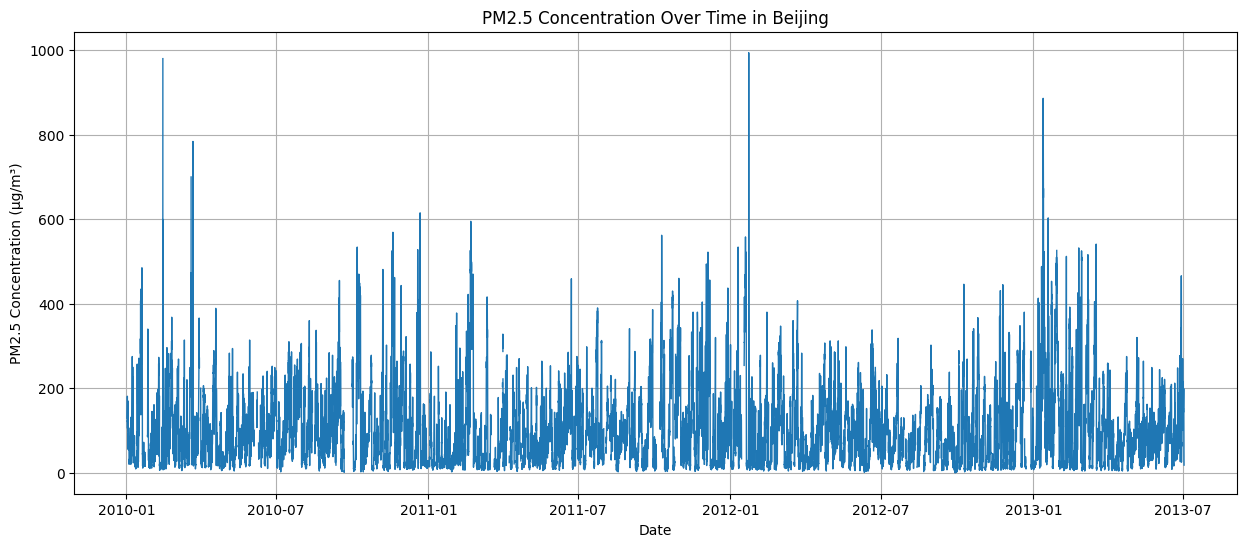

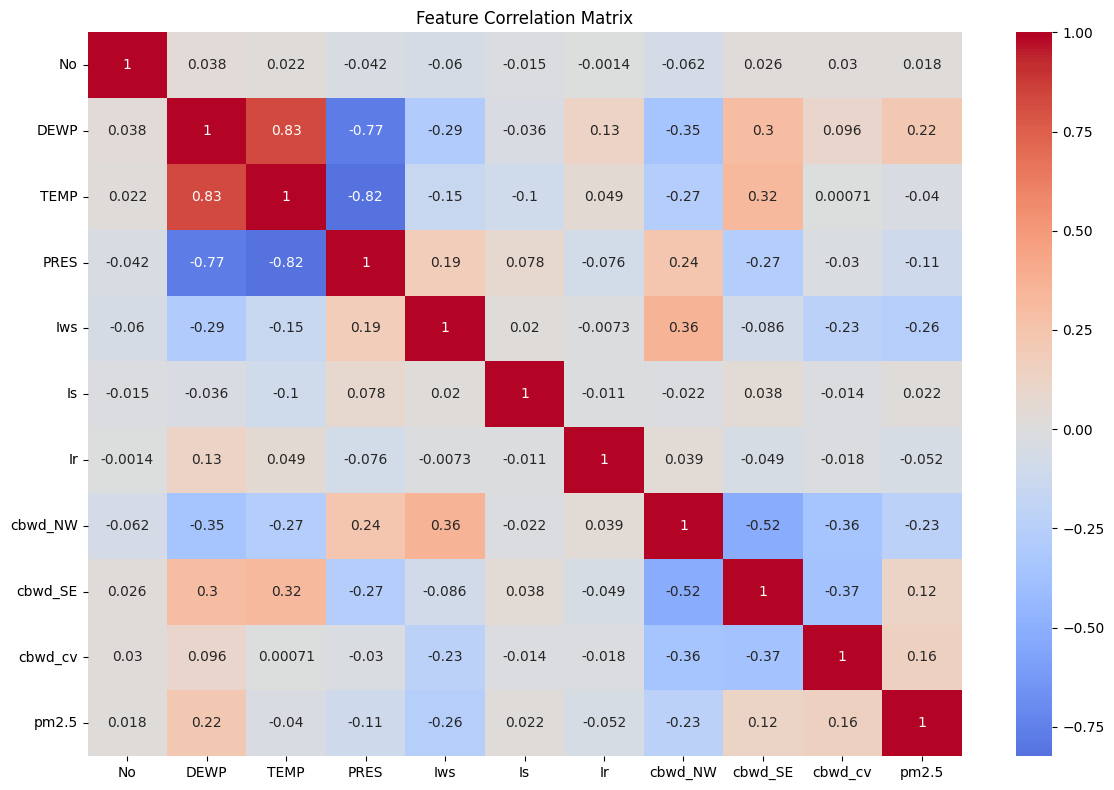

In [50]:
# Visualize and analyze data

def analyze_data(df):
    print('Summary of data:')
    print('-' * 30)
    print(df.describe())

    # Find out the missing values
    print(df.isnull().sum())

    # Plot PM2.5 time series
    plt.figure(figsize=(15, 6))
    plt.plot(df['datetime'], df['pm2.5'], linewidth=1)
    plt.title('PM2.5 Concentration Over Time in Beijing')
    plt.xlabel('Date')
    plt.ylabel('PM2.5 Concentration (μg/m³)')
    plt.grid(True)
    plt.show()
    
    # Correlation matrix
    plt.figure(figsize=(12, 8))
    correlation = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

analyze_data(df_train)

In [9]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
# train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [12]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [13]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [14]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [15]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [23]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [16]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test)

NameError: name 'X_train' is not defined

In [28]:
# Reshape the scaled data for LSTM input
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

NameError: name 'X_train_scaled' is not defined

In [12]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [13]:
# define model
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()



c:\Users\yiish\Documents\MYPROJECTS\time-series-forecasting\my-venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - lambda: 126.5407 - loss: 16662.4277
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 89.0062 - loss: 8389.7393
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 80.9626 - loss: 6959.8423
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 75.9793 - loss: 6143.3574
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - lambda: 72.8048 - loss: 5644.9180
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 71.2663 - loss: 5370.4209
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 72.0487 - loss: 5521.5469
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 72.1136 - loss: 5517.6484
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 71.7764 - loss: 5506.5249
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 71.8665 - loss: 5519.4722


959/959 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


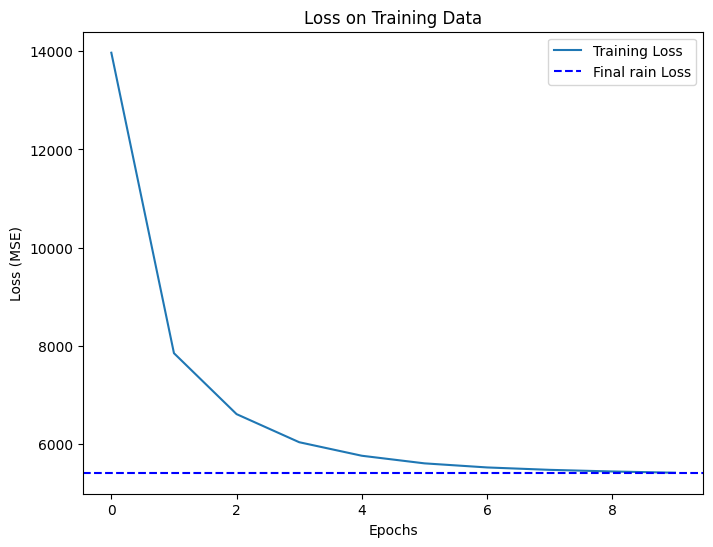

Final Training Loss (MSE): 5401.645244685721


In [15]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [25]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
